# 7 함수 데커레이터와 클로저
- 자기만의 데커레이터를 구현하고자 한다면 클로저를 속속들이 이해해야하며, 그러고 나면 nonlocal 이 필요해진다.
- 데커레이터에서 사용하는 것 외에도, 클로저는 콜백을 이용한 효율적인 비동기 프로그래밍과 필요에 따라 함수형 스타일로 코딩하는데도 필수적임
- 이 장의 궁극적인 목표는 아주 단순한 데커레이터에서부터 복잡한 매개변수화된 데커레이터에 이르기까지 함수 데커레이터가 정확히 어떻게 작동하는지 설명하는 것


목표 도달 전 살펴봐야할 내용들
- 파이썬이 데커레이터 구문을 평가하는 방식
- 변수가 지역 변수인지 파이썬이 판단하는 방식
- 클로저의 존재 이유와 작동 방식
- nonlocal 로 해결할 수 있는 문제

기반 갖춘 뒤 다룰 수 있는 심도있는 데커레이터 주제
- 잘 작동하는 데커레이터 구현하기
- 표준 라이브러리에서 제공하는 재미있는 데커레이터들
- 매개변수화된 데커레이터 구현하기

# 7.1 데커레이터 기본 지식
- 데커레이터는 다른 함수를 인수로 받는 콜러블(데커레이트된함수)이다.
- 데커레이터는 데커레이트된 함수에 어떤 처리를 수행하고, 함수를 반환하거나 함수를 다른 함수나 콜러블 객체로 대체한다.

```python
# 다음 코드와 같이 decorate 라는 이름의 데커레이터가 있다고 가정하자.
@decorate
def target():
    print('running target()')
    

# 위는 아래와 같음

def target():
    print('running target()')
    
target = decorate(target)
    
    
```

In [1]:
def deco(func):
    def inner():
        print('running inner()')
    return inner

@deco
def target():
    print('running target()')

In [2]:
target()

running inner()


In [3]:
print(target)

<function deco.<locals>.inner at 0x0000012A84566B80>


# 7.2 파이썬이 데커레이터를 실행하는 시점
- 테커레이터의 핵심 특징은 테커레이트된 함수가 정의된 직후에 실행된다는 것이다. 이는 일반적으로 파이썬이 모듈을 로딩하는 시점, 즉 <b>임포트 타임</b>에 실행된다.
- 일반적으로 실제 코드에서는 데커레이터를 정의하는 모듈과 데커레이터를 적용하는 모듈을 분리해서 구현한다.
- 실제 코드에서 대부분의 데커레터는 내부 함수를 정의해서 반환한다.

In [4]:
registry = []

def register(func):
    print('running register(%s)' %func)
    registry.append(func)
    return func

@register
def f1():
    print('running f1()')
    
@register
def f2():
    print('running f2()')
    
def f3():
    print('running f3()')
    
def main():
    print('running main()')
    print('registry -> ', registry)
    f1()
    f2()
    f3()
    
if __name__ == '__main__':
    main()

running register(<function f1 at 0x0000012A84566AF0>)
running register(<function f2 at 0x0000012A84566040>)
running main()
registry ->  [<function f1 at 0x0000012A84566AF0>, <function f2 at 0x0000012A84566040>]
running f1()
running f2()
running f3()


In [5]:
import registration

running register(<function f1 at 0x0000012A845669D0>)
running register(<function f2 at 0x0000012A84566E50>)


In [6]:
registration.registry

[<function registration.f1()>, <function registration.f2()>]

# 7.3 데커레이터로 개선한 전략 패턴

In [1]:
promos = []

def promotion(promo_func):
    promos.append(promo_func)
    return promo_func

@promotion
def fidelity(order):
    """충성도 포인트가 1000점 이상인 고객에게 전체 5% 할인 적용"""
    return order.total() * 0.05 if order.customer.fidelity >= 1000 else 0

@promotion
def bulk_item(order):
    """20개 이상의 동일 상품을 구입하면 10% 할인 적용"""
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount

@promotion
def large_order(order):
    """10종류 이상의 상품을 구입하면 전체 7% 할인 적용"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * 0.07
    return 0 

def best_promo(order):
    """최대로 할인받은 금액을 반환한다."""
    return max(promo(order) for promo in promos)

# 7.4 변수 범위 규칙
- 7.4 장 공부 목적
    - 대부분의 데커레이터는 데커레이트된 함수를 변경한다. 
        - 즉 내부 함수를 정의하고 그것을 반환하여 데커레이트된 함수를 대체한다.
        - 내부 함수를 사용하는 코드는 제대로 작동하기 위해 거의 항상 클로저에 의존한다.
        - 클로저를 이해하기 위해 먼저 파이썬에서 변수 범위의 작동 방식에 대해 자세히 살펴보자.
- 파이썬은 함수 본체를 컴파일 할 때 전역 변수와 동일한 이름의 지역 변수(b)가 있으면 b 가 함수 안에서 할당되므로 b를 지역 변수로 판단한다.
    - 인터프리터가 b를 전역 변수로 다루기 원한다면 global 키워드를 이용해서 선언해야함

In [43]:
# 지역 및 전역 변수를 읽는 함수
def f1(a):
    print(a)
    print(b)

In [3]:
print(f1(3))

3


NameError: name 'b' is not defined

In [6]:
b = 6
f1(3)

3
6


In [7]:
# 함수 본체 안에서 값을 할당하기 때문에 지역 변수가 되는 b
# 파이썬이 함수 본체를 컴파일할 때 b 가 함수 안에서 할당되므로 b 를 지역 변수로 판단
# 파이썬은 변수가 선언되어 있기를 요구하지 않지만, 함수 본체 안에서 할당된 변수는 지역 변수로 판단하기 때문
b = 6
def f2(a):
    print(a)
    print(b)
    b = 9

In [9]:
f2(3)

3


UnboundLocalError: local variable 'b' referenced before assignment

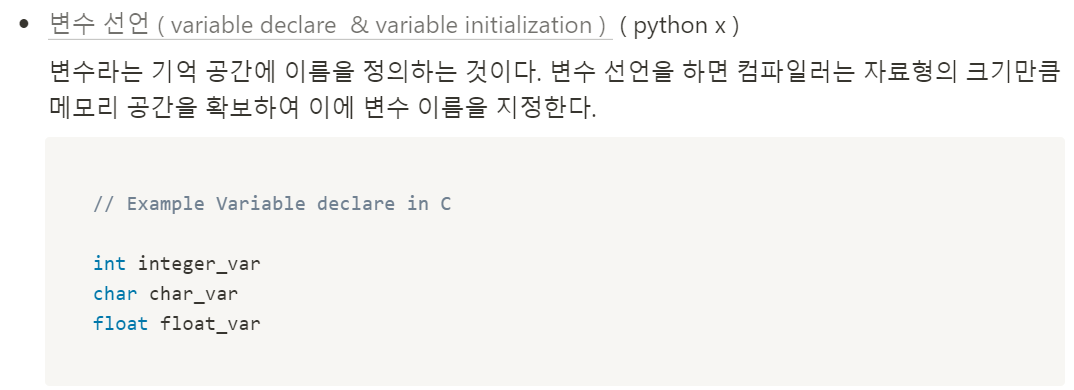

further study :  https://stackoverflow.com/questions/11007627/python-variable-declaration

In [10]:
# 함수 안에 할당하는 문장이 있지만 인터프리터가 b 를 전역 변수로 다루기 원한다면 global 키워드를 이용해서 선언
b = 6
def f3(a):
    global b
    print(a)
    print(b)
    b = 9

In [11]:
f3(3)

3
6


In [12]:
b

9

In [13]:
f3(3)

3
9


In [14]:
b = 30
b

30

In [44]:
# 바이트 코드 비교
from dis import dis
dis(f1)

  3           0 LOAD_GLOBAL              0 (print)
              2 LOAD_FAST                0 (a)
              4 CALL_FUNCTION            1
              6 POP_TOP

  4           8 LOAD_GLOBAL              0 (print)
             10 LOAD_GLOBAL              1 (b)
             12 CALL_FUNCTION            1
             14 POP_TOP
             16 LOAD_CONST               0 (None)
             18 RETURN_VALUE


In [ ]:
def f1(a):
    print(a)
    print(b)

In [16]:
dis(f2)

  3           0 LOAD_GLOBAL              0 (print)
              2 LOAD_FAST                0 (a)
              4 CALL_FUNCTION            1
              6 POP_TOP

  4           8 LOAD_GLOBAL              0 (print)
             10 LOAD_FAST                1 (b)
             12 CALL_FUNCTION            1
             14 POP_TOP

  5          16 LOAD_CONST               1 (9)
             18 STORE_FAST               1 (b)
             20 LOAD_CONST               0 (None)
             22 RETURN_VALUE


In [ ]:
b = 6
def f2(a):
    print(a)
    print(b)
    b = 9

# 7.5 클로저
- 클로저는 함수 본체에서 정의하지 않고 참조하는 비전역(nonglobal) 변수를 포함한 확장 범위를 가진 함수다.
    - 함수가 익명 함수인지 여부는 중요하지 않다.
    - 함수 본체 외부에 정의된 비전역 변수에 접근할 수 있다.
    - 함수를 정의할 때 존재하던 자유 변수에 대한 바인딩을 유지하는 함수이다. 따라서 함수를 정희하는 범위가 사라진 후에 함수를 호출해도 자유변수에 접근할 수 있다.


- 어떤 함수가 클로저이기 위해서 다음 세 가지 조건을 만족해야한다
    - 해당 함수는 어떤 함수 내의 중첩된 함수여야 한다.
        - 함수가 비전역 외부 변수를 다루는 경우는 그 함수가 다른 함수 안에 정의된 경우뿐이다.
    - 해당 함수는 자신을 둘러싼 ( enclose ) 함수 내의 상태값을 반드시 참조해야 한다.
    - 해당 함수를 둘러싼 함수는 이 함수를 반환해야한다. ( 객체로서 반환 해야함. => func()가 아니라 func 로 반환해야함 ) 
    - ref : https://shoark7.github.io/programming/python/closure-in-python

In [18]:
class Averager():
    def __init__(self):
        self.series = []
        
    def __call__(self, new_value):
        self.series.append(new_value)
        total = sum(self.series)
        return total/len(self.series)

In [19]:
avg = Averager()
print(avg(10))

10.0


In [20]:
avg(11)

10.5

In [21]:
avg(12)

11.0

In [22]:
# 예제 7-9
def make_averager():
    series = []
    
    def averager(new_value):
        series.append(new_value)
        total = sum(series)
        return total/len(series)
    
    return averager

In [23]:
avg = make_averager()
print(avg(10))
print(avg(11))
print(avg(12))

10.0
10.5
11.0


- series 는 지역 범위에 바인딩 되어있지 않은 변수인 자유 변수이기 때문에 avg() 함수가 series 를 참조할 수 있었음

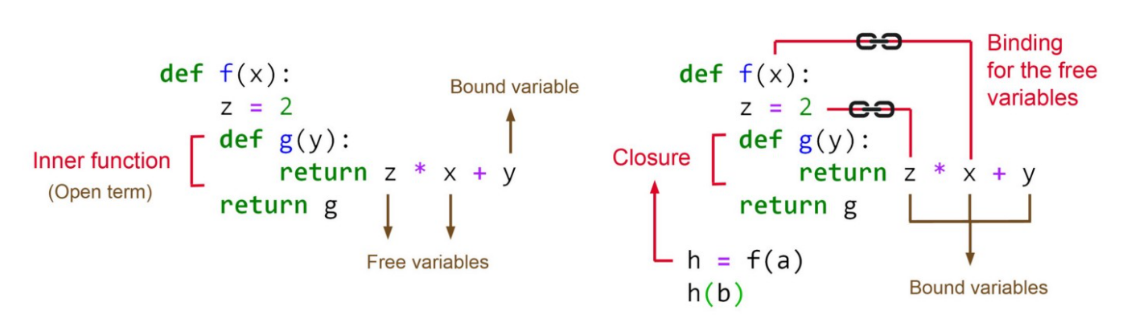

파이썬이 컴파일된 함수 본체를 나타내는 \_\_code__ 속성 안에 지역 변수와 자유 변수의 이름을 어떻게 저장하는지 알 수 있다.
- series 에 대한 바인딩은 반환된 avg() 함수의 \_\_closure__ 속성에 저장된다.
    - \_\_closure__ 의 각 항목은 avg.\_\_code__.co_freevars 이름에 대응된다.

In [29]:
avg.__code__.co_varnames

('new_value', 'total')

In [30]:
avg.__code__.co_freevars

('series',)

In [31]:
avg.__code__.co_freevars

('series',)

In [32]:
avg.__closure__

(<cell at 0x000002610F1901F0: list object at 0x000002610FBCEB80>,)

In [33]:
avg.__closure__[0].cell_contents

[10, 11, 12]

# 7.6 nonlocal 선언
- 변수를 nonlocal 로 선언하면 함수 안에서 변수에 새로운 값을 할당하더라도 그 변수는 자유 변수임을 나타낸다.
- 예제 7-14 와 같이 새로운 값을 nonlocal 변수에 할당하면 클로저에 저장된 바인딩이 변경된다.

In [7]:
# 예제 7-13 잘못된 고위 함수 
# 고위 함수 : 함수로 인수로 받거나, 함수를 결과로 반환하는 함수.
# make_averager는 다른 함수를 인수로 받지 않았기 때문에 decorator 가 아님
def make_averager():
    cnt   = 0
    total = 0
    
    def averager(new_value):
        cnt   += 1 
        total += new_value
        return total / cnt
    
    return averager

- cnt += 1 을 풀어서 쓰면 cnt = cnt + 1 을 의미하므로, 즉 averager 본체 안에서 cnt 변수를 할당하고 있으므로 cnt 변수를 지역 변수로 만듦
- 예제 7-9 에서는 series 변수를 함수 본체 내에서 할당하지 않았기 때문에 에러가 발생하지 않았음. 리스트가 가변형인 것을 이용한 것
    - 숫자, 문자열, 튜플 등 불변형은 읽을 수만 있고 값을 갱신할 수 없기 때문에 예제 7-13과 같이 변수를 다시 바인딩하면 암묵적으로 cnt 라는 지역 변수를 생성 => cnt 는 더 이상 자유 변수가 아니므로 클로저에 저장되지 않는다.

In [8]:
avg = make_averager()
avg(10)

UnboundLocalError: local variable 'cnt' referenced before assignment

- 예제 7-13의 문제 해결책으로서 변수를 nonlocal 에 선언. 변수를 nonlocal 로 선언하면 함수 안에서 변수에 새로운 값을 할당하더라도 그 변수는 자유 변수임을 나타냄.
- 새로운 값을 nonlocal 변수에 할당하면 클로저에 저장된 바인딩이 변경된다.

In [9]:
# 예제 7-14
def make_averager():
    cnt   = 0
    total = 0
    
    def averager(new_value):
        nonlocal cnt, total
        cnt   += 1
        total += new_value
        return total / cnt
    
    return averager

#### dis 를 통한 binding 확인

In [45]:
# 예제 7-13
def make_averager():
    cnt   = 0
    total = 0
    
    def averager(new_value):
        cnt   += 1 
        total += new_value
        return total / cnt
    
    return averager

In [46]:
dis(make_averager())

  6           0 LOAD_FAST                1 (cnt)
              2 LOAD_CONST               1 (1)
              4 INPLACE_ADD
              6 STORE_FAST               1 (cnt)

  7           8 LOAD_FAST                2 (total)
             10 LOAD_FAST                0 (new_value)
             12 INPLACE_ADD
             14 STORE_FAST               2 (total)

  8          16 LOAD_FAST                2 (total)
             18 LOAD_FAST                1 (cnt)
             20 BINARY_TRUE_DIVIDE
             22 RETURN_VALUE


In [47]:
# 예제 7-14
def make_averager():
    cnt   = 0
    total = 0
    
    def averager(new_value):
        nonlocal cnt, total
        cnt   += 1
        total += new_value
        return total / cnt
    
    return averager

In [48]:
dis(make_averager())

  8           0 LOAD_DEREF               0 (cnt)
              2 LOAD_CONST               1 (1)
              4 INPLACE_ADD
              6 STORE_DEREF              0 (cnt)

  9           8 LOAD_DEREF               1 (total)
             10 LOAD_FAST                0 (new_value)
             12 INPLACE_ADD
             14 STORE_DEREF              1 (total)

 10          16 LOAD_DEREF               1 (total)
             18 LOAD_DEREF               0 (cnt)
             20 BINARY_TRUE_DIVIDE
             22 RETURN_VALUE


# 7.7 간단한 데커레이터 구현하기

In [18]:
import time

def clock(func):
    def clocked(*args):
        t0 = time.perf_counter()
        result = func(*args)
        elapsed = time.perf_counter() - t0
        name = func.__name__
        arg_str = ', '.join(repr(arg) for arg in args)
        print('[%0.8fs] %s(%s) -> %r ' %(elapsed, name , arg_str, result))
        return result
    return clocked

In [11]:
import time

@clock
def snooze(seconds):
    time.sleep(seconds)
    
@clock
def factorial(n):
    return 1 if n<2 else n * factorial(n-1)

if __name__ == '__main__':
    print('*' * 40, 'Calling snooze(.123)' )
    snooze(.123)
    print('*' * 40, 'Calling factorial(6)' )
    print('6! = ', factorial(6))

**************************************** Calling snooze(.123)
[0.12424200s] snooze(0.123) -> None 
**************************************** Calling factorial(6)
[0.00000080s] factorial(1) -> 1 
[0.00004070s] factorial(2) -> 2 
[0.00006640s] factorial(3) -> 6 
[0.00009100s] factorial(4) -> 24 
[0.00011920s] factorial(5) -> 120 
[0.00014530s] factorial(6) -> 720 
6! =  720


## 7.7.1 작동 과정

```python

#1은 #2 와 같이 실행된다. 

#1
@clock
def factorial(n):
    return 1 if n < 2 else n * factorial(n-1)


#2
def factorial(n):
    return 1 if n<2 else n*factorial(n-1)

factorial = clock(factorial)
```

In [13]:
print(factorial.__name__)

clocked


In [16]:
# 예제 7 - 17 개선된 clock 데커레이터

import time
import functools

def clock(func):
    @functools.wraps(func)
    def clocked(*args,**kwargs):
        t0 = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - t0
        name = func.__name__
        arg_lst  = []
        if args : 
            arg_lst.append(', '.join(repr(arg) for arg in args ))
        if kwargs : 
            pairs = ['%s = %r' %(k,w) for k,w in sorted(kwargs.items())]
            arg_lst.append(', '.join(pairs))
        arg_str = ', '.join(pairs)
        print('[%0.8fs] %s(%s) -> %r' %( elapsed, name, arg_str, result))
        return result
    return clocked

# 7.8 표준 라이브러리에서 제공하는 데커레이터

## 7.8.1 functools.lru_cache() 를 이용한 메모이제이션

In [19]:
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n-1) + fibonacci(n-2)

if __name__ == '__main__':
    print(fibonacci(6))

[0.00000070s] fibonacci(1) -> 1 
[0.00000070s] fibonacci(0) -> 0 
[0.00012900s] fibonacci(2) -> 1 
[0.00000050s] fibonacci(1) -> 1 
[0.00017460s] fibonacci(3) -> 2 
[0.00000060s] fibonacci(1) -> 1 
[0.00000050s] fibonacci(0) -> 0 
[0.00007120s] fibonacci(2) -> 1 
[0.00063460s] fibonacci(4) -> 3 
[0.00000030s] fibonacci(1) -> 1 
[0.00000030s] fibonacci(0) -> 0 
[0.00003780s] fibonacci(2) -> 1 
[0.00000030s] fibonacci(1) -> 1 
[0.00008590s] fibonacci(3) -> 2 
[0.00076230s] fibonacci(5) -> 5 
[0.00000030s] fibonacci(1) -> 1 
[0.00000030s] fibonacci(0) -> 0 
[0.00004280s] fibonacci(2) -> 1 
[0.00000050s] fibonacci(1) -> 1 
[0.00008800s] fibonacci(3) -> 2 
[0.00000040s] fibonacci(1) -> 1 
[0.00000040s] fibonacci(0) -> 0 
[0.00005210s] fibonacci(2) -> 1 
[0.00019280s] fibonacci(4) -> 3 
[0.00100110s] fibonacci(6) -> 8 
8


In [20]:
import functools

@functools.lru_cache()
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n-1) + fibonacci(n-2)

if __name__ == '__main__':
    print(fibonacci(6))

[0.00000070s] fibonacci(1) -> 1 
[0.00000090s] fibonacci(0) -> 0 
[0.00017900s] fibonacci(2) -> 1 
[0.00021720s] fibonacci(3) -> 2 
[0.00025280s] fibonacci(4) -> 3 
[0.00029140s] fibonacci(5) -> 5 
[0.00034100s] fibonacci(6) -> 8 
8


## 7.8.2 단일 디스패치를 이용한 범용 함수

In [21]:
import html

def htmlize(obj):
    content = html.escape(repr(obj))
    return '<pre>{}</pre>'.format(content)

In [23]:
from functools import singledispatch
from collections import abc
import numbers
import html

@singledispatch
def htmlize(obj):
    content = html.escape(repr(obj))
    return '<pre>{}</pre>'.format(content)

@htmlize.register(str)
def _(text):
    content = html.escape(text).replace('\n','<br>\n')
    return '<p>{}</p>'.format(content)

@htmlize.register(numbers.Integral)
def _(n):
    return '<pre>{0} (0x{0:x})</pre>'.format(n)

@htmlize.register(tuple)
@htmlize.register(abc.MutableSequence)
def _(seq):
    inner = '</li>\n<li>'.join(htmlize(item) for item in seq)
    return '<ul>\n<li>{}</li>\n</ul>'.format(inner)

In [26]:
print(htmlize({1,2,3}))
print(htmlize(abs))
print(htmlize('Heimlich & Co.\n- a game'))
print(htmlize(42))
print(htmlize(['alpha',66,{3,2,1}]))

<pre>{1, 2, 3}</pre>
<pre>&lt;built-in function abs&gt;</pre>
<p>Heimlich &amp; Co.<br>
- a game</p>
<pre>42 (0x2a)</pre>
<ul>
<li><p>alpha</p></li>
<li><pre>66 (0x42)</pre></li>
<li><pre>{1, 2, 3}</pre></li>
</ul>


In [27]:
htmlize('Heimlich & Co.\n- a game')

'<p>Heimlich &amp; Co.<br>\n- a game</p>'

# 7.9 누적된 데커레이터

```python
#1 과 #2 는 동일한 코드이다.

#1
@d1
@d2
def f():
    print('f')
    
#2 
f = d1(d2(f))
```

# 7.10 매개변수화된 데커레이터

In [29]:
registry = []

def register(func):
    print('running register(%s)' % func)
    registry.append(func)
    return func

@register
def f1():
    print('running f1()')
    
print('running main()')
print('registry ->', registry)
f1()

running register(<function f1 at 0x000002C6B2C7F5E0>)
running main()
registry -> [<function f1 at 0x000002C6B2C7F5E0>]
running f1()


## 7.10.1 매개변수화된 등록 데커레이터

In [30]:
registry = set()

def register(active=True):
    def decorate(func):
        print('running register(active=%s)->decorate(%s)' % (active, func))
        if active:
            registry.add(func)
        else:
            registry.discard(func)
            
        return func
    return decorate

@register(active=False)
def f1():
    print('running f1()')
    
@register()
def f2():
    print('running f2()')

def f3():
    print('running f3()')

running register(active=False)->decorate(<function f1 at 0x000002C6B2C7F8B0>)
running register(active=True)->decorate(<function f2 at 0x000002C6B2C7F5E0>)


In [31]:
registry

{<function __main__.f2()>}

In [32]:
register()(f3)

running register(active=True)->decorate(<function f3 at 0x000002C6B2C63670>)


<function __main__.f3()>

In [33]:
registry

{<function __main__.f2()>, <function __main__.f3()>}

In [34]:
register(active = False)(f2)

running register(active=False)->decorate(<function f2 at 0x000002C6B2C7F5E0>)


<function __main__.f2()>

In [35]:
registry

{<function __main__.f3()>}

## 7.10.2 매개변수화된 clock 데커레이터

In [36]:
import time

DEFAULT_FMT = '[{elapsed:0.8f}s] {name}({args}) -> {result}'

def clock(fmt=DEFAULT_FMT): 
    def decorate(func): 
        def clocked(*_args): 
            t0 = time.time()
            _result = func(*_args) 
            elapsed = time.time() - t0
            name = func.__name__
            args = ', '.join(repr(arg) for arg in _args)
            result = repr(_result) 
            print(fmt.format(**locals())) 
            return _result
        return clocked
    return decorate


if __name__=='__main__':
    
    @clock()
    def snooze(seconds):
        time.sleep(seconds)
        
    for i in range(3):
        snooze(.123)

[0.13119149s] snooze(0.123) -> None
[0.12603235s] snooze(0.123) -> None
[0.12312388s] snooze(0.123) -> None


In [37]:
@clock('{name}: {elapsed}s')
def snooze(seconds):
    time.sleep(seconds)
    
for i in range(3):
    snooze(.123)

snooze: 0.1254878044128418s
snooze: 0.1235496997833252s
snooze: 0.12344741821289062s


In [38]:
@clock('{name}({args}) dt={elapsed:0.3f}s')
def snooze(seconds):
    time.sleep(seconds)
    
for i in range(3):
    snooze(.123)

snooze(0.123) dt=0.125s
snooze(0.123) dt=0.125s
snooze(0.123) dt=0.124s
